#### This notebook takes the 3-D tSNE projection of our sample and finds a 3-D rotation of that distribution that produces a 2-D projection that maximizes the range of our 'CIV distance' metric




---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import fits
import richardsplot
import pandas as pd
from mpl_toolkits import mplot3d

In [2]:
def figsize(hscale, 
            vscale=(np.sqrt(5.0)-1.0)/2.0,
            fig_width_pt = 336.0):
   

    """
    Get the fig_width_pt by inserting \the\textwidth into LaTeX document.

    hscale is fraction of text width you want.

    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width*vscale                   # height in inches
    fig_size = [fig_width, fig_height]

    return fig_size

In [3]:
import palettable

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.5,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 16,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis
    "axes.formatter.limits":[-5, 5],    # use sci notation if log10 of axis range is smaller than first or larger than second 
    "axes.formatter.useoffset":False,
    "font.size": 16,
    "legend.fontsize": 12,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 16,              # Font size of numbers 
    "ytick.labelsize": 16,
    'xtick.major.width':1, 
    'xtick.minor.width':1, 
    'ytick.major.width':1, 
    'ytick.minor.width':1, 
    'xtick.major.size':10,             # size of tickmarks in points
    'xtick.minor.size':5, 
    'ytick.major.size':10, 
    'ytick.minor.size':5,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'figure.autolayout': True,
    "figure.figsize": figsize(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)


csdark = palettable.colorbrewer.qualitative.Dark2_5.mpl_colors
cspurple = palettable.colorbrewer.sequential.BuPu_4.mpl_colors
csorange = palettable.colorbrewer.sequential.YlOrBr_5.mpl_colors




Need to load in data from PGv2_DR7

In [4]:
infoShen = pd.read_csv('grdr7_Shen2011_targ_uni.csv', skiprows=1, names=["name","RAx","DECx","SDSSNAME","RA","DEC","redshift","TARG_FLAG","UNI_FLAG","COLOR_FLAG","MIZ2","BALFLAGShen","FIRSTFRTYPE","FINTREST6CM","LOGFNU2500","R6CM2500A","LOGL3000","LOGL1350","Separation"])
infoHewett = pd.read_csv('grdr7_180126.weights', sep = ' ', names=["name", "redshift", "W1", "W2", "W3", "W4", "W5", "W6"])

#Need to format weights for Scikit-Learn
weights = infoHewett[infoHewett.columns[2:]]
#print weights
X = np.array(weights)

# Array of each of the 6 weights
W1 = X[:,0]
W2 = X[:,1]
W3 = X[:,2]
W4 = X[:,3]
W5 = X[:,4]
W6 = X[:,5]

#We are going to want to restrict the redshift range, do it like this.
zem = np.array(infoHewett['redshift'])

#Read in radio data
R = np.array(infoShen['R6CM2500A']).astype(float)

# Number with z<1.75
zmask = ((zem>1.645)&(zem<=1.6519))
RLmask = (R>10)

#Mask to pick out color-selected objects (ignores radio selected and NaN [non-DR7 objects])
cMask = np.array(infoShen['COLOR_FLAG'])

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [5]:
projTSNE3 = np.load('tSNE3_DR7.npy')
projTSNE3col = projTSNE3[cMask>0]
projTSNE3radcol = projTSNE3[(cMask>0)&(RLmask)]
projTSNE3colz = projTSNE3[(cMask>0)&(zmask)]

In [6]:
#Want to ignore objects w/o values in the CIV Vector distance column
#This will hopefully be resolved after we get new dr14 ICA reconstructions
sudo_df = pd.read_csv('../SpringFinalFigs_moreParams.csv')

#need this extra mask for skiprows before sort below - confusing but necessary
civ_mask = sudo_df[['RM_DIST_UNSCALE']].values.flatten()

sudo_df.sort_values('col1', inplace=True)

#Need this array to match with projection arrays since shapes match
CIV_VEC = sudo_df[['RM_DIST_SCALE']].values.flatten() 

null = (civ_mask==0.0)
skiprows = []
for i in range(len(null)): 
    if null[i]: skiprows.append(i+1)

infoTrevor = pd.read_csv('../SpringFinalFigs_moreParams.csv', skiprows=skiprows)
infoTrevor.sort_values('col1', inplace=True) #sort target radio data based on Paul's data
civ_vec = infoTrevor[['RM_DIST_SCALE']].values.flatten()
civ_vec.shape

(48,)

<IPython.core.display.Javascript object>


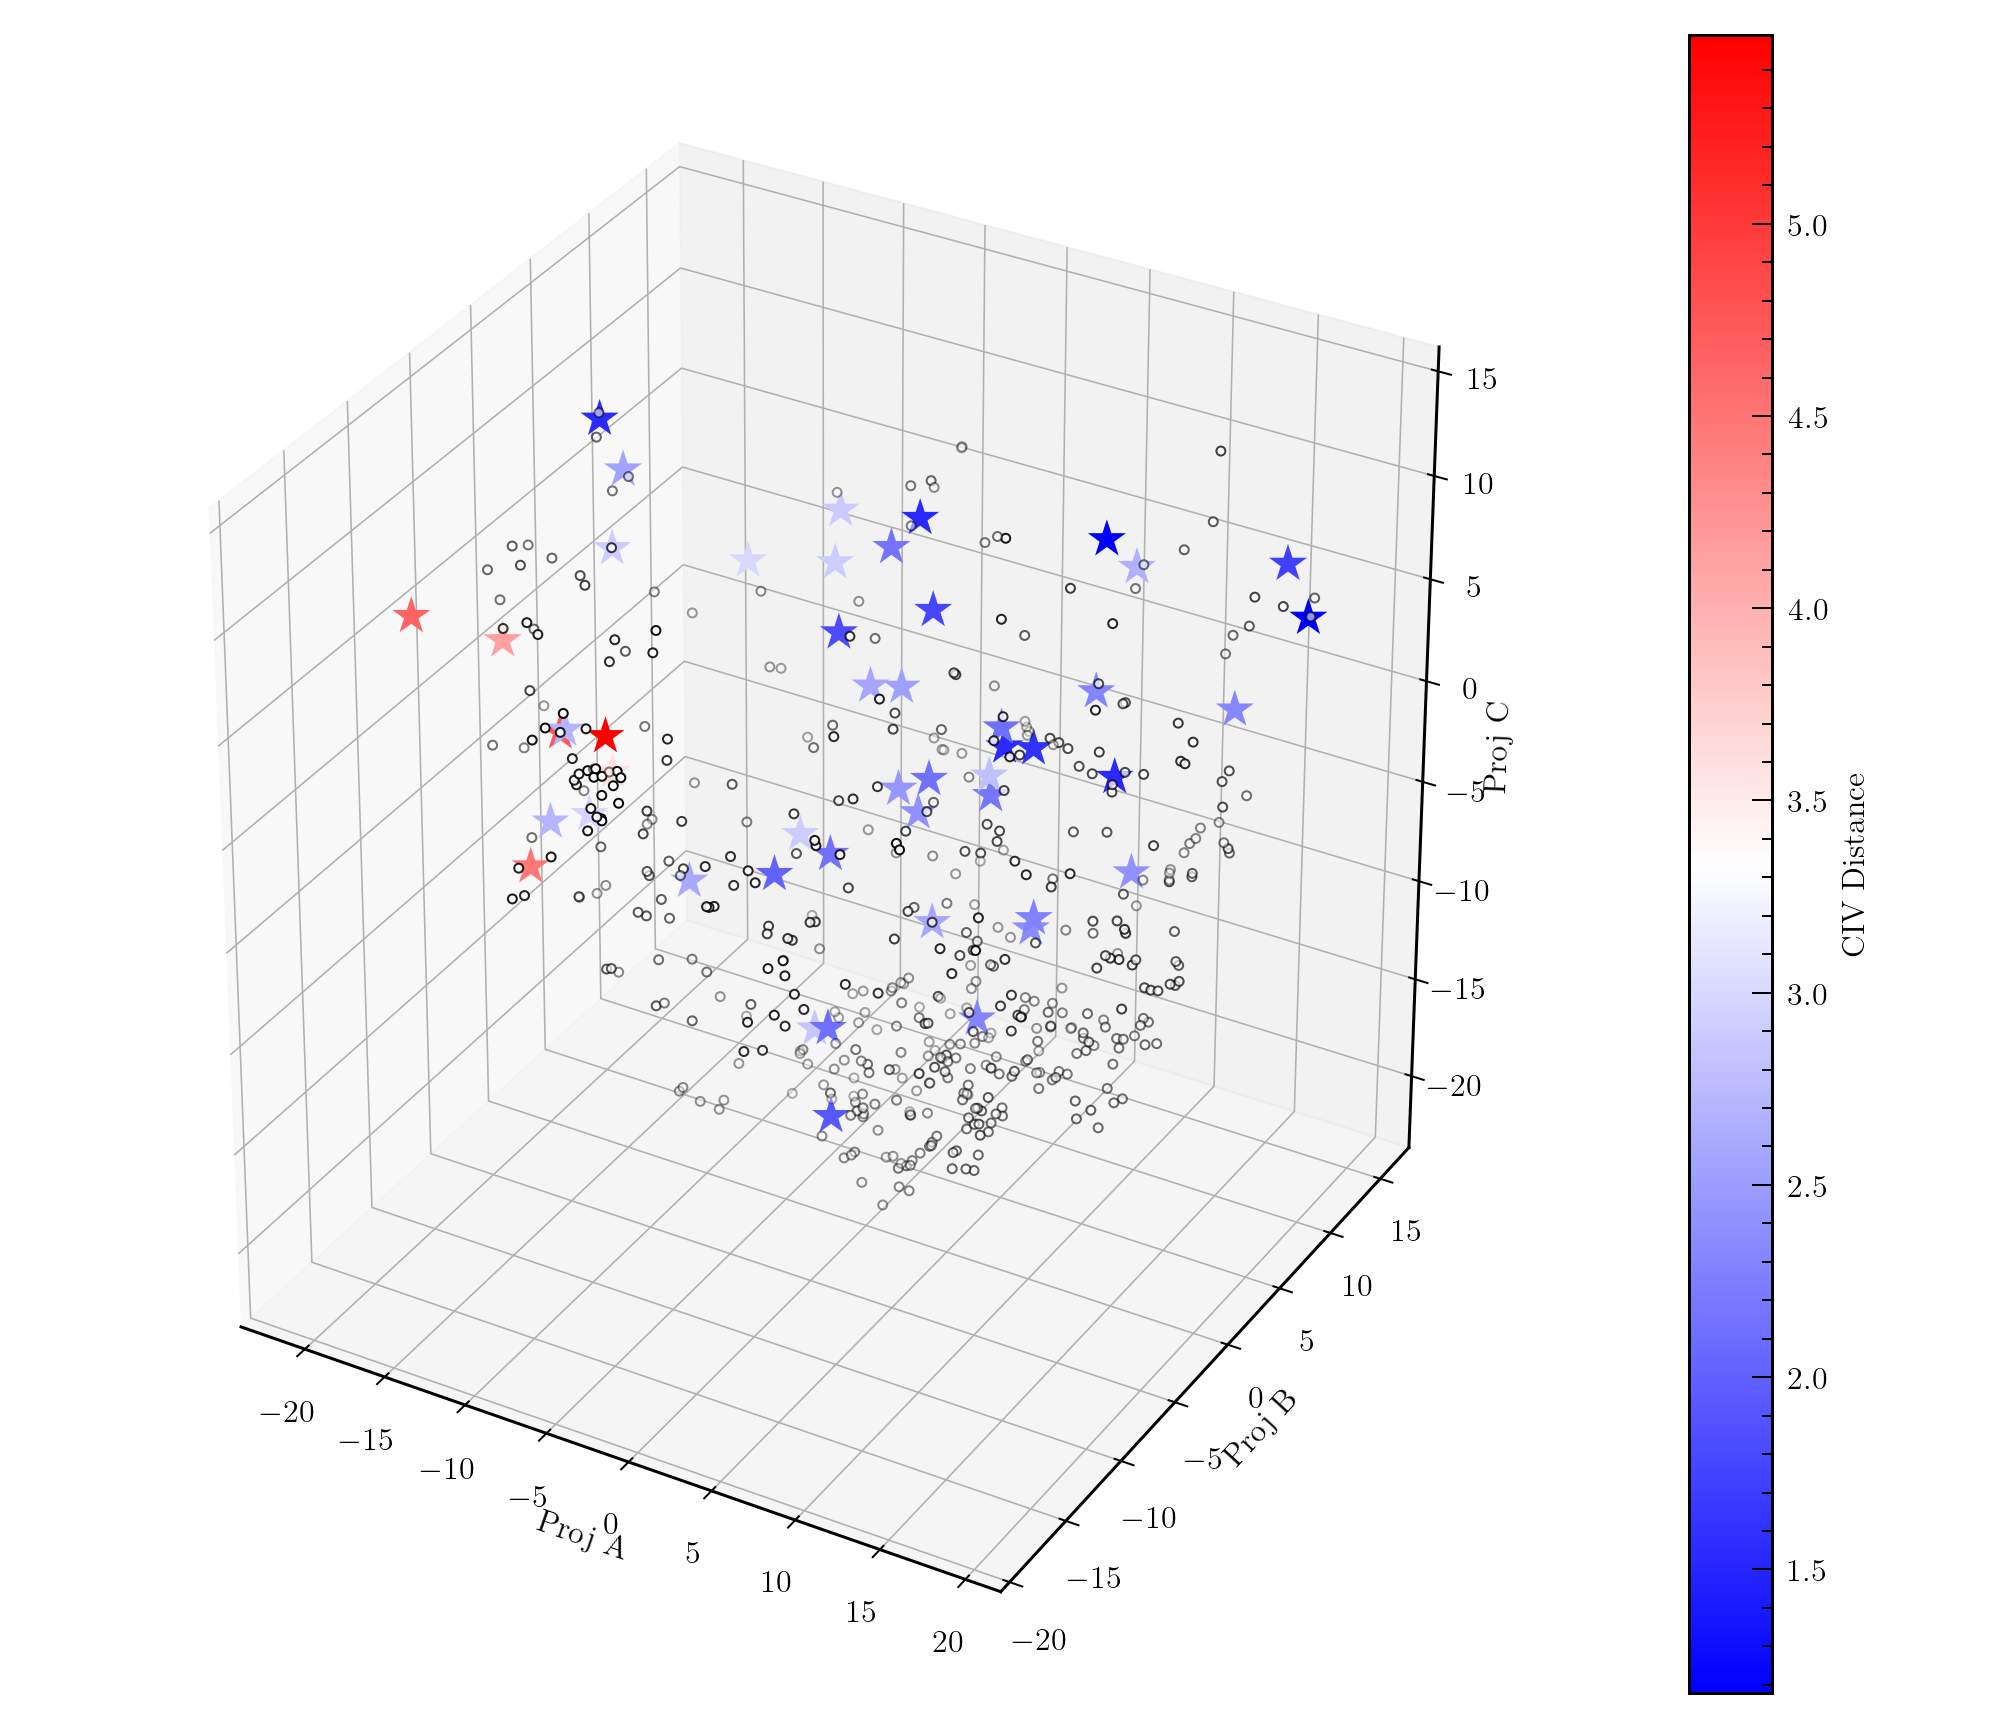

In [21]:
%matplotlib notebook

fig = plt.figure(figsize=(14,12))
ax = plt.axes(projection="3d")

ax.scatter3D(projTSNE3radcol[:,0], projTSNE3radcol[:,1], projTSNE3radcol[:,2], c='w', edgecolor="k",s=20)
p = ax.scatter3D(projTSNE3colz[:,0][CIV_VEC>0], projTSNE3colz[:,1][CIV_VEC>0], projTSNE3colz[:,2][CIV_VEC>0], c=CIV_VEC[CIV_VEC>0], cmap="bwr", edgecolor="None",s=400, marker="*")

#Take avg of N reddest/bluest points
Navg = 2

hiciv_pts = CIV_VEC[CIV_VEC>0].argsort()[-Navg:][::-1]
red_pts = np.array([projTSNE3colz[CIV_VEC>0][hiciv_pts[i]] for i in range(len(hiciv_pts))])
avgred = red_pts.mean(axis=0)

lowciv_pts = CIV_VEC[CIV_VEC>0].argsort()[:Navg][::-1]
blue_pts = np.array([projTSNE3colz[CIV_VEC>0][lowciv_pts[i]] for i in range(len(lowciv_pts))])
avgblue = blue_pts.mean(axis=0)

#Avg of reddest pts
#ax.scatter3D(avgred[0], avgred[1], avgred[2], c="orange", edgecolor="k",s=400, marker="*")

#Avg of bluest pts
#ax.scatter3D(avgblue[0], avgblue[1], avgblue[2], c="m", edgecolor="k",s=400, marker="*")


cbar = fig.colorbar(p)
cbar.ax.set_ylabel("CIV Distance")

ax.set_xlabel("Proj A")
ax.set_ylabel("Proj B")
ax.set_zlabel("Proj C")

#plt.savefig("tSNE3_CIV.pdf")

plt.show()

In [8]:
#This is a nice way to track which quadrant each point is in
class tSNEpt():
    def __init__(self, pt):
        self.__x = pt[0]
        self.__y = pt[1]
        self.__z = pt[2]
        self.__quad = 0
    
    def get_quad(self):
        return self.__quad
    
    def set_quad(self):
        x = self.__x
        y = self.__y
        
        #We actually only care about the 2-D projection
        #that maximizes the distance between ends of CIV distribution
        if x >=0 and y >=0:
            self.__quad = 1
        elif x < 0 and y >= 0:
            self.__quad = 2
        elif x < 0 and y < 0:
            self.__quad = 3
        elif x >= 0 and y < 0:
            self.__quad = 4

In [9]:
def rotation(theta):
    return np.array(([np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]))

In [10]:
maxnum = 0
projTSNE3_rot = projTSNE3.copy()
projTSNE3col_rot = projTSNE3_rot[cMask>0]
projTSNE3radcol_rot = projTSNE3_rot[(cMask>0)&(RLmask)]
projTSNE3colz_rot = projTSNE3_rot[(cMask>0)&(zmask)]
opt_rotation = projTSNE3_rot


#Store all points as objects in list to iterate through
pt_objects = []
for i in range(len(projTSNE3)):
    pt_objects.append(tSNEpt(projTSNE3[i]))

#Create list of quadrants each point is in
quadrants = []
for pt in pt_objects:
    pt.set_quad()
    quadrants.append(pt.get_quad())

#Iterate through each quadrant
for i in range(1, max(quadrants)+1):
    print(quadrants.count(i))
    if quadrants.count(i) > maxnum: 
        maxnum = quadrants.count(i)
        opt_rotation = projTSNE3_rot
        

2591
1674
2627
1761


^That's the idea.  Now, want to throw it in a loop and:

* Rotate all points in the xy plane some angle $\theta_{xy}$
    * For each xy rotation, rotate the points in the yz plane in increments $\phi_{yz}$ all the way through to $2\pi$


* Compute xy distance between 'most and least' CIV distance.  If it's greater than the current max distance, update that value and change 'opt_rotation' to the current rotation


\begin{equation*}
R = 
\begin{pmatrix}
\cos\theta & -\sin\theta  \\
\sin\theta & \cos\theta
\end{pmatrix}
\end{equation*}

In [11]:
for theta in np.arange(0, 2*np.pi, np.pi/6): print(theta) 

0.0
0.5235987755982988
1.0471975511965976
1.5707963267948966
2.0943951023931953
2.617993877991494
3.141592653589793
3.665191429188092
4.1887902047863905
4.71238898038469
5.235987755982988
5.759586531581287


In [12]:
np.array([projTSNE3[:,0], projTSNE3[:,1]]).T

array([[ 3.3992834, -0.6594   ],
       [ 7.2845545, -5.2929096],
       [14.227501 ,  8.701422 ],
       ...,
       [12.092185 ,  7.266762 ],
       [11.2877655, -7.0342875],
       [-1.0075307,  7.4919   ]], dtype=float32)

<IPython.core.display.Javascript object>


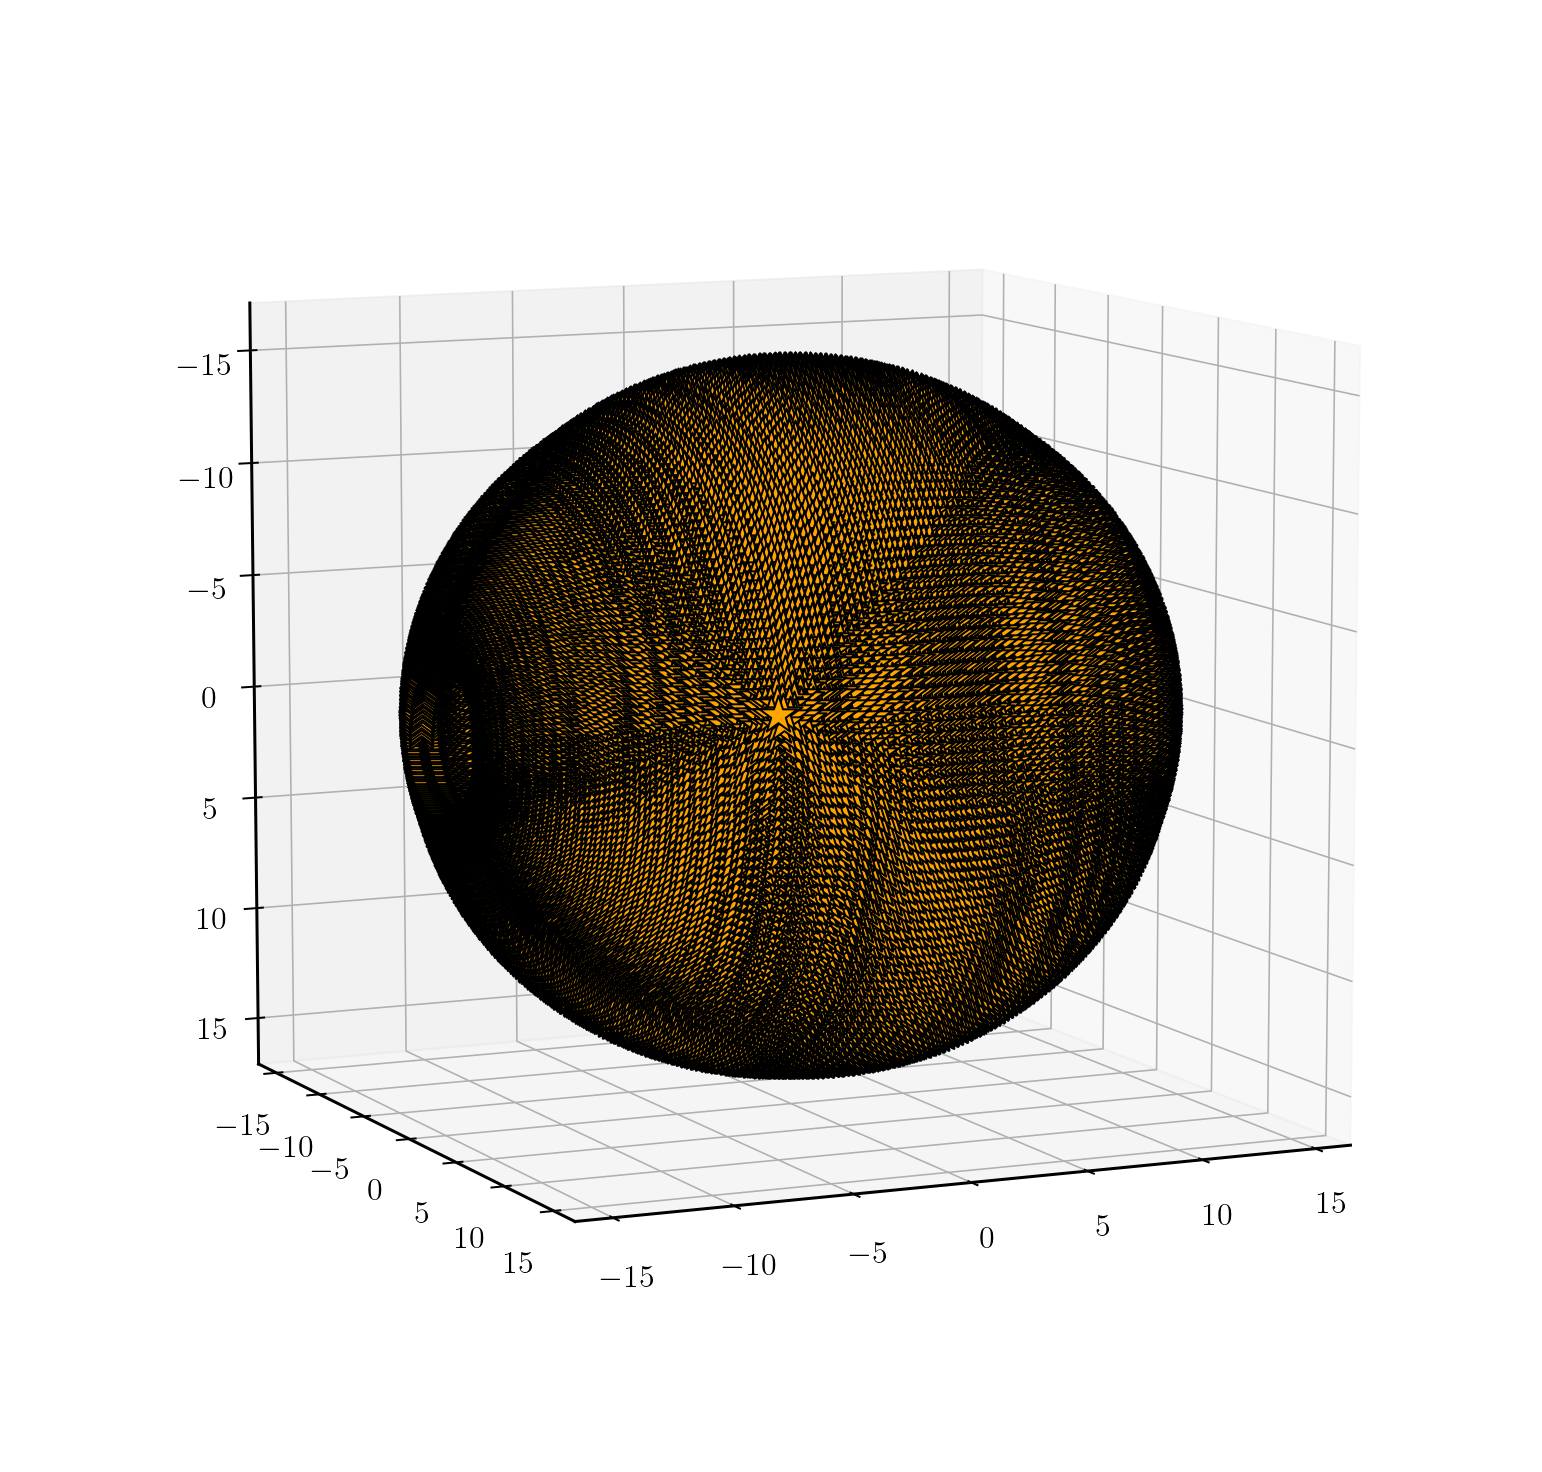

In [22]:
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

#Increase for smaller rotation increments
N = 100

#Take Navg reddest/bluest points to define red/blue area of distribution - only for 
#comparing distributions, doesn't actually change points at all
Navg = 9

#Track how far apart red/blue pts are in best distribution 
maxdist = 0

#Want to rotate a copy of the original tSNE3 projection
projTSNE3_rot = projTSNE3.copy()
opt_rotation = projTSNE3_rot

for theta in np.arange(0, 2*np.pi, np.pi/N):
    #Go Back to start for each rotation
    projTSNE3_rot = projTSNE3.copy()
    xy = np.array([projTSNE3[:,0], projTSNE3[:,1]]).T
    
    projTSNE3_rot[:,0:2] = np.matmul(xy, rotation(theta))
    
    for phi in np.arange(0, 2*np.pi, np.pi/N):
        #Go back to theta for each phi rotation
        projTSNE3_rot2 = projTSNE3_rot.copy()
        yz = np.array([projTSNE3_rot[:,1], projTSNE3_rot[:,2]]).T
        projTSNE3_rot2[:,1:3] = np.matmul(yz, rotation(phi))
        
        projTSNE3radcol_rot2 = projTSNE3_rot2[(cMask>0)&(RLmask)]
        projTSNE3colz_rot2 = projTSNE3_rot2[(cMask>0)&(zmask)]
        
        
        #Now do stuff to check if this rotation is better
        #Get indices of highest CIV distance points
        hiciv_pts = CIV_VEC[CIV_VEC>0].argsort()[-Navg:][::-1]
        red_pts = np.array([projTSNE3colz_rot2[CIV_VEC>0][hiciv_pts[i]] for i in range(len(hiciv_pts))])
        avgred = red_pts.mean(axis=0)
        #Get indices of lowest CIV distance points, excluding missing measurements
        lowciv_pts = CIV_VEC[CIV_VEC>0].argsort()[:Navg][::-1]
        blue_pts = np.array([projTSNE3colz_rot2[CIV_VEC>0][lowciv_pts[i]] for i in range(len(lowciv_pts))])
        avgblue = blue_pts.mean(axis=0)
        
        #Avg of reddest pts
        ax.scatter3D(avgred[0], avgred[1], avgred[2], c="orange", edgecolor="k",s=400, marker="*")

        #Avg of bluest pts
        ax.scatter3D(avgblue[0], avgblue[1], avgblue[2], c="m", edgecolor="k",s=400, marker="*")



        civ_range = np.sqrt((avgred[0] - avgblue[0])**2 + (avgred[1] - avgblue[1])**2)
        if civ_range > maxdist:
            maxdist = civ_range
            opt_rotation = projTSNE3_rot2

plt.show()

^Covers pretty much every rotation

<IPython.core.display.Javascript object>


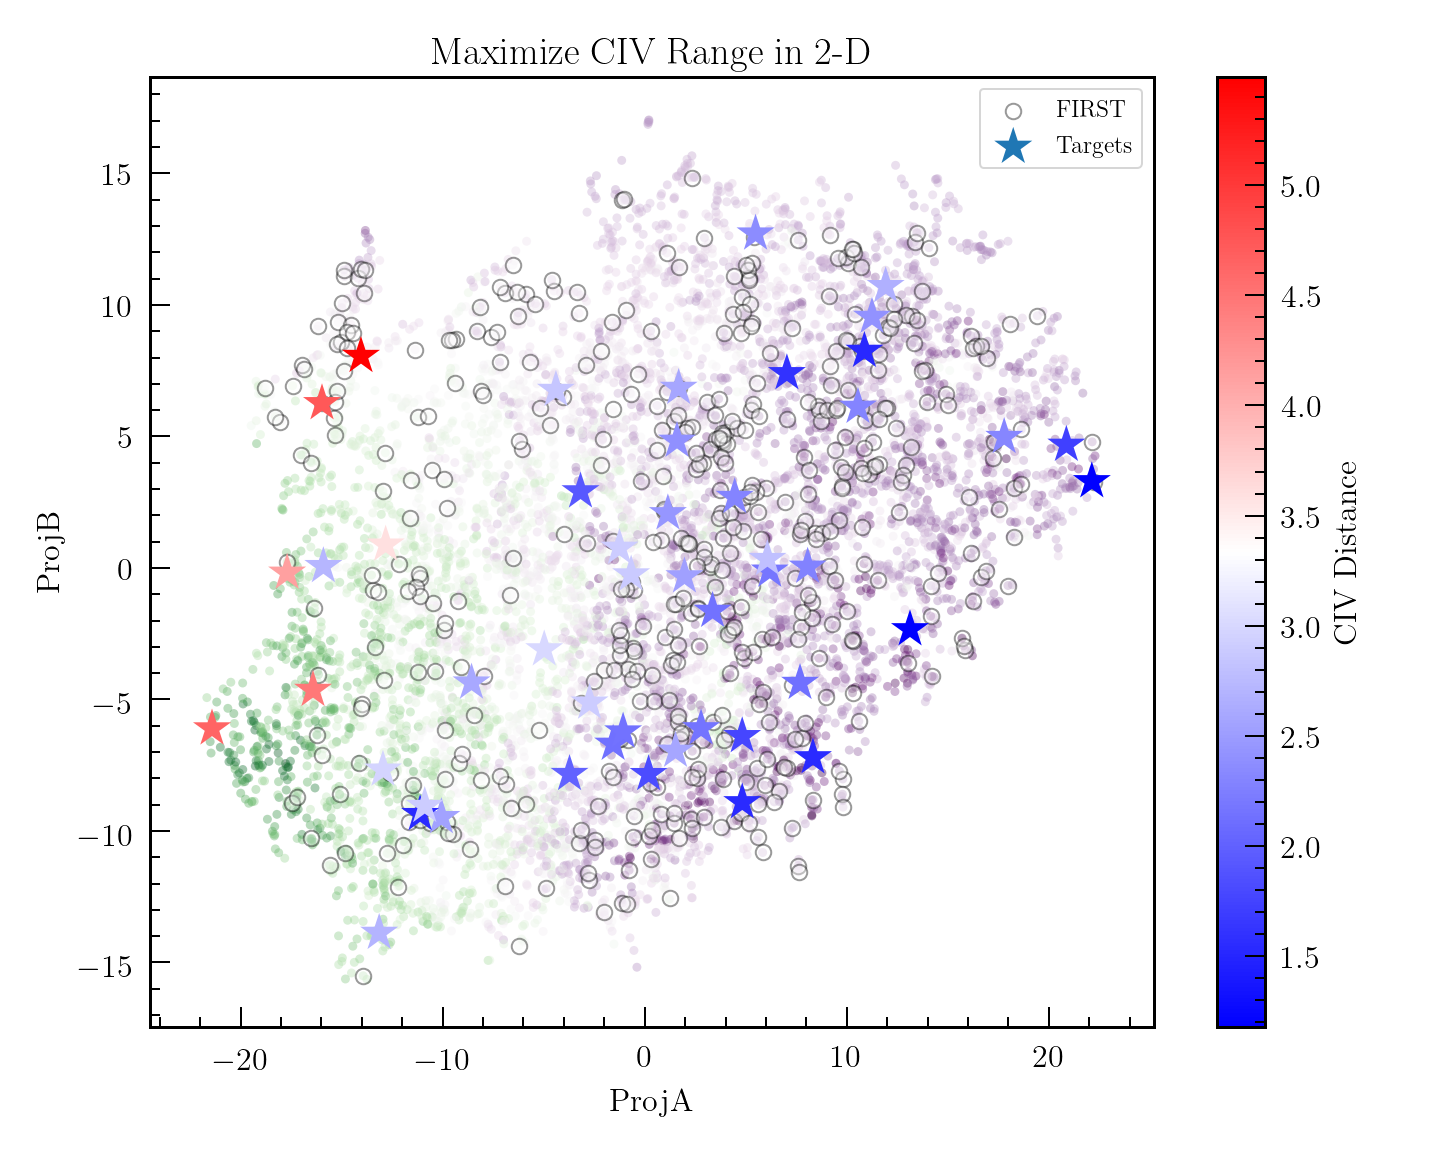

In [23]:
opt_rotation_col = opt_rotation[(cMask>0)]
opt_rotation_colz = opt_rotation[(cMask>0)&(zmask)]
opt_rotation_radcol = opt_rotation[(cMask>0)&(RLmask)]


plt.figure(figsize=(10,8))

plt.scatter(opt_rotation_col[:,0], opt_rotation_col[:,1], c=W1[cMask>0], cmap="PRGn", 
            edgecolor="None", s=20, alpha=0.4)

plt.scatter(opt_rotation_radcol[:,0], opt_rotation_radcol[:,1], 
            c='w', edgecolor="k", s=60, alpha=0.4, label="FIRST")

plt.scatter(opt_rotation_colz[CIV_VEC>0][:,0], opt_rotation_colz[CIV_VEC>0][:,1], 
            c=civ_vec[civ_vec>0], cmap="bwr", edgecolor="None",s=400, marker="*", label="Targets")



cbar = plt.colorbar()
cbar.ax.set_ylabel("CIV Distance")

plt.xlabel("ProjA")
plt.ylabel("ProjB")
plt.title("Maximize CIV Range in 2-D")
plt.legend(loc="best")

plt.tight_layout()
#plt.savefig("3D_rotationPlots/maxCIVrange_tSNE3_avg{}.pdf".format(Navg))

This is the 2-D projection of our 3-D tSNE analysis which maximizes the range of the CIV distance metric

Green to purple colormap represents W1 from 6-component ICA analysis

---

Now maximize RLF in a quadrant

In [26]:
N = 100

maxfrac = 0.0
projTSNE3_rot = projTSNE3.copy()
opt_rotation = projTSNE3_rot

for theta in np.arange(0, 2*np.pi, np.pi/N):
    #Go Back to start for each rotation
    projTSNE3_rot = projTSNE3.copy()
    xy = np.array([projTSNE3[:,0], projTSNE3[:,1]]).T
    projTSNE3_rot[:,0:2] = np.matmul(xy, rotation(theta))
    
    for phi in np.arange(0, 2*np.pi, np.pi/N):
        #Go back to theta for each phi rotation
        projTSNE3_rot2 = projTSNE3_rot.copy()
        yz = np.array([projTSNE3_rot[:,1], projTSNE3_rot[:,2]]).T
        projTSNE3_rot2[:,1:3] = np.matmul(yz, rotation(phi))
        
        projTSNE3radcol_rot2 = projTSNE3_rot2[(cMask>0)&(RLmask)]
        projTSNE3colz_rot2 = projTSNE3_rot2[(cMask>0)&(zmask)]
        
        
        #Store all Color-selected points as objects in list to iterate through
        pt_objects = []
        for i in range(len(projTSNE3_rot2)):
            pt_objects.append(tSNEpt(projTSNE3_rot2[i]))

        #Create list of quadrants each of the points are in
        quadrants = []
        for pt in pt_objects:
            pt.set_quad()
            quadrants.append(pt.get_quad())
            
        #Store all FIRST points as objects in list to iterate through
        pt_radcol_objects = []
        for i in range(len(projTSNE3radcol_rot2)):
            pt_radcol_objects.append(tSNEpt(projTSNE3radcol_rot2[i]))

        #Create list of quadrants each of the points are in
        quadrants_radcol = []
        for pt in pt_radcol_objects:
            pt.set_quad()
            quadrants_radcol.append(pt.get_quad())

        #Iterate through each quadrant
        for i in range(1, max(quadrants)+1):
            if quadrants_radcol.count(i)/quadrants.count(i) > maxfrac: 
                maxfrac = quadrants_radcol.count(i)/quadrants.count(i)
                print("Max Quadrant RLF = %.2f" % (100*maxfrac))
                opt_rotation = projTSNE3_rot2

Max Quadrant RLF = 6.48
Max Quadrant RLF = 9.31
Max Quadrant RLF = 9.71
Max Quadrant RLF = 9.91
Max Quadrant RLF = 10.19
Max Quadrant RLF = 10.69
Max Quadrant RLF = 10.83
Max Quadrant RLF = 11.07
Max Quadrant RLF = 11.45
Max Quadrant RLF = 11.49
Max Quadrant RLF = 11.61
Max Quadrant RLF = 11.81
Max Quadrant RLF = 11.96
Max Quadrant RLF = 12.09
Max Quadrant RLF = 12.13
Max Quadrant RLF = 12.15
Max Quadrant RLF = 12.27
Max Quadrant RLF = 12.28
Max Quadrant RLF = 12.32
Max Quadrant RLF = 12.35
Max Quadrant RLF = 12.37
Max Quadrant RLF = 12.37
Max Quadrant RLF = 12.40
Max Quadrant RLF = 12.40
Max Quadrant RLF = 12.42
Max Quadrant RLF = 12.45
Max Quadrant RLF = 12.51
Max Quadrant RLF = 12.61
Max Quadrant RLF = 12.65
Max Quadrant RLF = 12.67
Max Quadrant RLF = 12.74
Max Quadrant RLF = 12.75
Max Quadrant RLF = 12.80
Max Quadrant RLF = 12.80
Max Quadrant RLF = 12.87
Max Quadrant RLF = 12.94
Max Quadrant RLF = 13.02
Max Quadrant RLF = 13.04
Max Quadrant RLF = 13.09
Max Quadrant RLF = 13.10
Max 

<IPython.core.display.Javascript object>


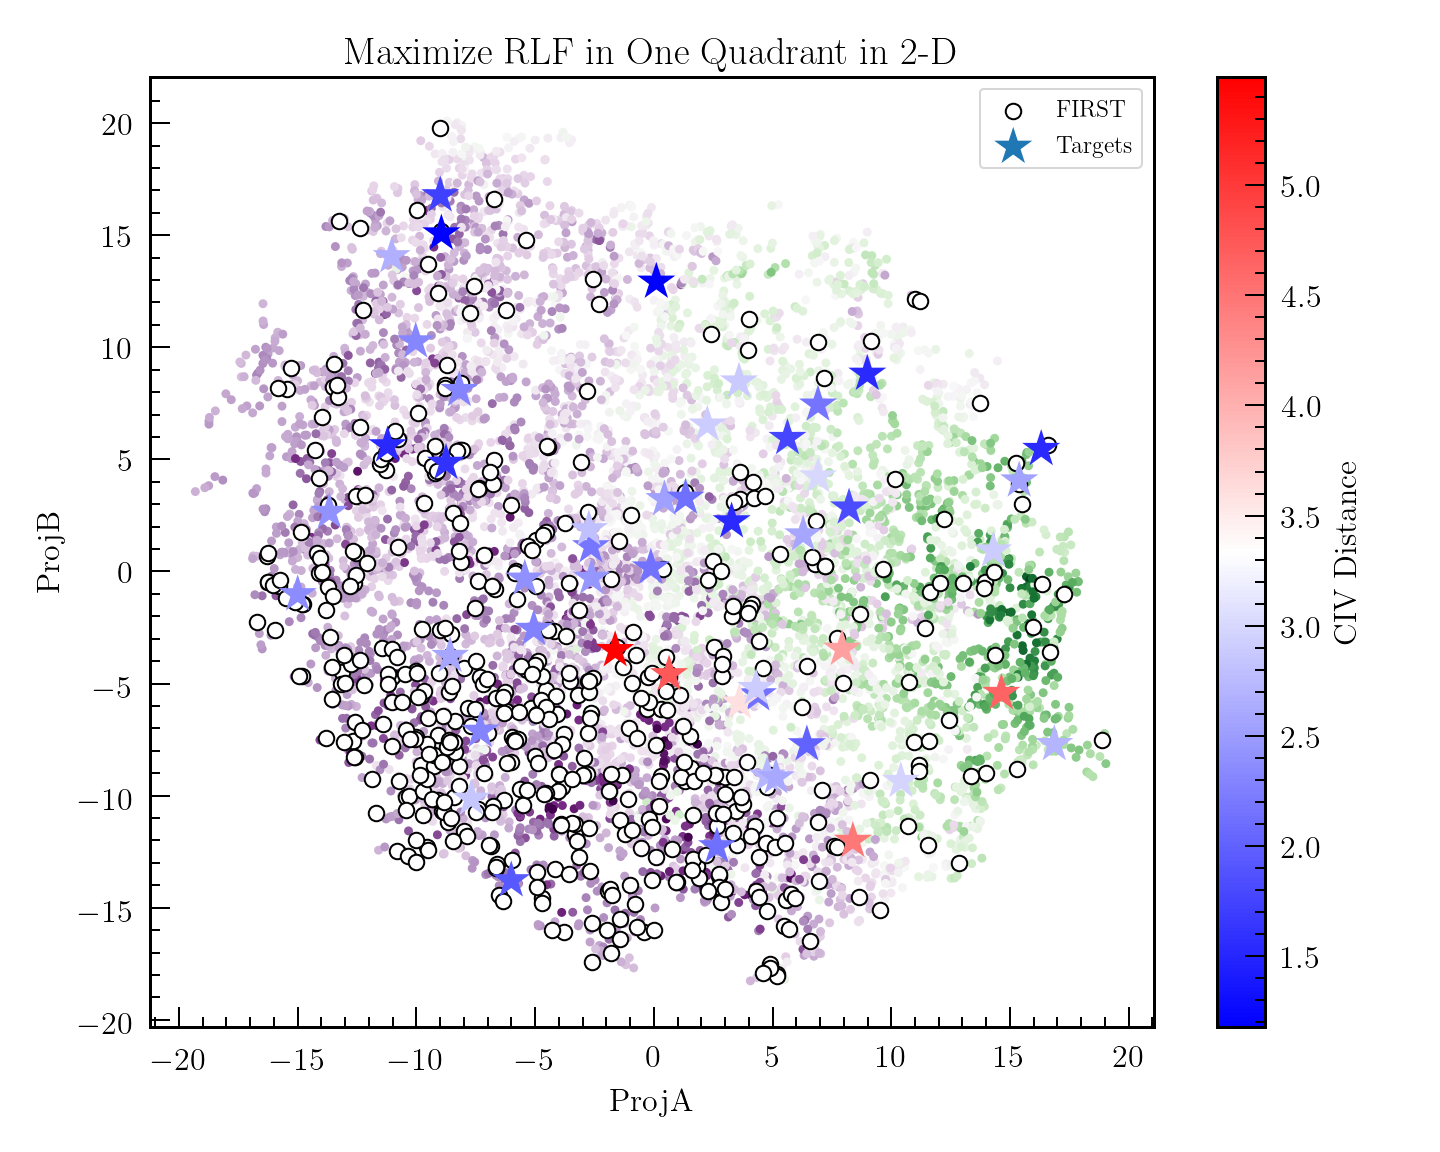

Quad 1 RLF = 1.94 percent
Quad 2 RLF = 3.46 percent
Quad 3 RLF = 13.49 percent
Quad 4 RLF = 4.57 percent


In [31]:
opt_rotation_col = opt_rotation[(cMask>0)]
opt_rotation_colz = opt_rotation[(cMask>0)&(zmask)]
opt_rotation_radcol = opt_rotation[(cMask>0)&(RLmask)]


plt.figure(figsize=(10,8))

plt.scatter(opt_rotation_col[:,0], opt_rotation_col[:,1], c=W1[cMask>0], cmap="PRGn", 
            edgecolor="None", s=20)

plt.scatter(opt_rotation_radcol[:,0], opt_rotation_radcol[:,1], 
            c='w', edgecolor="k", s=60,  label="FIRST")

plt.scatter(opt_rotation_colz[CIV_VEC>0][:,0], opt_rotation_colz[CIV_VEC>0][:,1], 
            c=civ_vec[civ_vec>0], cmap="bwr", edgecolor="None",s=400, marker="*", label="Targets")

cbar = plt.colorbar()
cbar.ax.set_ylabel("CIV Distance")

plt.xlabel("ProjA")
plt.ylabel("ProjB")
plt.title("Maximize RLF in One Quadrant in 2-D")
plt.legend(loc="best")
plt.savefig("3D_rotationPlots/maxRLFquadrant_tSNE3.pdf")
plt.show()

x  = opt_rotation[:,0]
y  = opt_rotation[:,1]

maskI = ((x>0)&(y>0))
maskII = ((x<=0)&(y>0))
maskIII = ((x<=0)&(y<=0))
maskIV = ((x>0)&(y<=0))

n_I = maskI.sum()
n_II = maskII.sum()
n_III = maskIII.sum()
n_IV = maskIV.sum()

xRL  = opt_rotation_radcol[:,0]
yRL  = opt_rotation_radcol[:,1]

mask1RL = ((xRL>0)&(yRL>0))
mask2RL = ((xRL<=0)&(yRL>0))
mask3RL = ((xRL<=0)&(yRL<=0))
mask4RL = ((xRL>0)&(yRL<=0))

RLFI = 100*(mask1RL.sum() / n_I)
RLFII = 100*(mask2RL.sum() / n_II)
RLFIII = 100*(mask3RL.sum() / n_III)
RLFIV = 100*(mask4RL.sum() / n_IV)

print ("Quad 1 RLF = %.2f percent" % RLFI)
print ("Quad 2 RLF = %.2f percent" % RLFII)
print ("Quad 3 RLF = %.2f percent" % RLFIII)
print ("Quad 4 RLF = %.2f percent" % RLFIV)